<a href="https://colab.research.google.com/github/timwong101/project-gam/blob/main/Original_Working_Mushrooms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gam

import numpy as np
import pandas as pd
import io

#from gam import gam


In [2]:
"""
Implementation of Spearman's Rho squared as a pairwise distance metric
Base on
http://www.plhyu.com/administrator/components/com_jresearch/files/publications/Mixtures_of_weighted_distance-based_models_for_ranking_data_with_applications_in_political_studies.pdf
TODO:
- add tests
"""

from sklearn.metrics import pairwise_distances
import numpy as np


def spearman_squared_distance(a, b):
    """
    Computes weighted Spearmans's Rho squared distance.  Runs in O(n).  
    Numpy for efficiency.
    Args:
        a, b: 1D numpy arrays of normalized local attributions - e.g. np.sum(a) =1
    Returns:
        distance: float >= 0 - the distance between the two attributions
    """

    order_penalty = (a - b) ** 2
    weight = np.multiply(a, b)

    distance = 1e4 * np.sum(np.multiply(order_penalty, weight))
    return distance


def spearman_squared_distance_legacy(r_1, r_2):
    """
    Computes a weighted Spearman's Rho squared distance. Runs in O(n)
    Args:
        r_1, r_2 (list): list of weighted rankings.
                       Index corresponds to an item and the value is the weight
                       Entries should be positive and sum to 1
                       Example: r_1 = [0.1, 0.2, 0.7]
    Returns: float >= representing the distance between the rankings
    """
    # confirm r_1 and r_2 have same lengths
    if len(r_1) != len(r_2):
        raise ValueError("rankings must contain the same number of elements")
    distance = 0

    for r_1_value, r_2_value in zip(r_1, r_2):
        order_penalty = (r_1_value - r_2_value) ** 2
        weight = r_1_value * r_2_value * 100 * 100
        distance += weight * order_penalty

    return distance


def pairwise_spearman_distance_matrix(rankings):
    """Returns Spearman Distances for the provided rankings
    Args:
        rankings (numpy.array): Normalized Attributions
    Returns:
        [array[array]]: Spearman Distance Matrix
    """
    return pairwise_distances(
        rankings, metric=spearman_squared_distance
    )


def pairwise_spearman_distance_matrix_legacy(rankings):
    """
    Computes a matrix of pairwise distance
    Args:
        rankings (list): each element is a list of weighted rankings (see ktau_weighted_distance)
    Returns: matrix (list of lists) containing pairwise distances
    """
    D = []
    for r_1 in rankings:
        row = []
        for r_2 in rankings:
            distance = spearman_squared_distance(r_1, r_2)
            row.append(distance)
        D.append(row)
    return D

In [3]:
"""
Implementation of Kendall's Tau as a pairwise distance metric
Base on
http://www.plhyu.com/administrator/components/com_jresearch/files/publications/Mixtures_of_weighted_distance-based_models_for_ranking_data_with_applications_in_political_studies.pdf
TOOD:
- consider optimizing using numpy
"""


def ktau_weighted_distance(r_1, r_2):
    """
    Computes a weighted kendall tau distance. Runs in O(n^2)
    Args:
        r_1, r_2 (list): list of weighted rankings.
                       Index corresponds to an item and the value is the weight
                       Entries should be positive and sum to 1
                       Example: r_1 = [0.1, 0.2, 0.7]
    Returns: float >= 0 representing the distance between the rankings
    """
    # confirm r_1 and r_2 have same lengths
    if len(r_1) != len(r_2):
        raise ValueError("rankings must contain the same number of elements")
    distance = 0

    for i in range(len(r_1) - 1):
        for j in range(i, len(r_1)):
            r_1_order = r_1[i] - r_1[j]
            r_2_order = r_2[i] - r_2[j]
            # check if i and j appear in a different order
            if r_1_order * r_2_order < 0:
                weight = r_1[i] * r_1[j] * r_2[i] * r_2[j]
                distance += 1 * weight
    return distance


def prep_data(X, Y):
    '''
    Data preprocessing step prior to doing merge sort/discovery of inversions
    1. Zip together x, y, and integer index
    2 Sort on X, and in the case of ties, sort on Y
    3. Remove X from the tuples (the first entry) since it's sorted we don't need to carry it
    4. return a list of (y_i, ind_i) for discovery of inversions
    Inputs:
        X, Y - two 1D array of weighted rankings
    Returns:
        yRankings - list of tuples containing
    '''
    assert(len(X) == len(Y))

    originalInd = list(range(len(X)))
    zipRankings = list(zip(X, Y, originalInd))
#    print('zipped rankings - ', zipRankings)

    # sort first by X, then by Y (secondary sort if items in X are equal)
#    zipRankings.sort(key=lambda item: (item[0], item[1]))
    zipRankings.sort(key=lambda item: (item[0]))
#    print('zipped sorted - ', zipRankings)
    # since X is sorted now (see above) - we can strip it off, and concentrate on (Y,index)
    yRankings = [(aTuple[1], aTuple[2]) for aTuple in zipRankings]
    return yRankings


def mergeSortInversions(arr, indList):
    '''
    Find inversions in 1D array of weighted rankings
    Inputs:  arr is 1D array of tuples (y_i, ind)
             indList - list of pairs of indices (used to get weights in distance calc)
    Returns:
        c - sorted array (not used, could clean up)
        inversions - interger count of inverted pairs
        indList - list of tuples containing indices (based on original list) of inverted pairs
    '''

    if len(arr) == 1:
        return arr, 0, indList
    else:
        midpt = int(len(arr) / 2)
        a = arr[:midpt]
        b = arr[midpt:]
        a, ai, indList = mergeSortInversions(a, indList)
        b, bi, indList = mergeSortInversions(b, indList)
        c = []
        i = 0
        j = 0
        inversions = 0 + ai + bi
    while i < len(a) and j < len(b):
        if a[i][0] <= b[j][0]:
            c.append(a[i])
            i += 1
            tmpInvList = []
        else:
            c.append(b[j])
            inversions += (len(a) - i)
            tmpInvList = [(a[i][1], b[j][1])]
#            print('inversion - i=:', i, ' j=', j, 'inv=', inversions, ' ind=', indList,
#                  'arr=', arr, a, b, 'a=', a[i][0], 'b=', b[j][0], 'tmpList = ', tmpInvList)

            j += 1
            indList.extend(tmpInvList)

    c += a[i:]
    c += b[j:]
    return c, inversions, indList


def distance_calc(x, y, indList):
    '''
    For use with merge sort discovered inversions
    Inputs:
       x &  y - 1D arrays of weights
       indList - list of tuples containing pairs of inversions
     Returns:
       d: calculated distance (scalar float)
     '''
#    print('input x = ', x)
#    print(' input y = ', y)
#    print('input indList - ', indList)
    d = 0
    for aTuple in indList:
        ind0 = aTuple[0]
        ind1 = aTuple[1]
        # conforms with logic in original code
        if (x[ind0] != x[ind1]) & (y[ind0] != y[ind1]):
            d += x[ind0] * x[ind1] * y[ind0] * y[ind1]
    return d


def mergeSortDistance(r1, r2):
    '''
    Utility function wrapping preprocessing, merge sort, and distance calc into 1 routine
    Inputs:
        r1, r2 - 1D arrays of rankings
    Returns:
        dist - kendall-tau distance
        inv - number of inversions found
    '''
    y_to_rank = prep_data(r1, r2)
#    print('List to sort - ', y_to_rank)
    indList = []
    c, inv, indList = mergeSortInversions(y_to_rank, indList)
    dist = distance_calc(r1, r2, indList)
#    print()
#    print('Sorted list - ', c)
#    print('Index list - ', indList)
    return dist


def pairwise_distance_matrix(rankings):
    from sklearn.metrics import pairwise_distances
    D = pairwise_distances( rankings, metric=mergeSortDistance)
    return D

def pairwise_distance_matrix_legacy(rankings):
    """
    Computes a matrix of pairwise distance
    Args:
        rankings (list): each element is a list of weighted rankings (see ktau_weighted_distance)
    Returns: matrix (list of lists) containing pairwise distances
    """
    D = []
    for r_1 in rankings:
        row = []
        for r_2 in rankings:
            # original method ~ O(n^2)
            # distance = ktau_weighted_distance(r_1, r_2)

            # updated method - using merge sort ~ O(nlogn)
            distance = mergeSortDistance(r_1, r_2)
            row.append(distance)
        D.append(row)
    return D

In [4]:
"""
Implementation of kmedoids using custom distance metric
Adaped from https://raw.githubusercontent.com/shenxudeu/K_Medoids/master/k_medoids.py
TODO:
- refactor and test components of implementation
"""
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import pairwise_distances


def _get_init_centers(n_clusters, n_samples):
    """Return random points as initial centers"""
    init_ids = []
    while len(init_ids) < n_clusters:
        _ = np.random.randint(0, n_samples)
        if _ not in init_ids:
            init_ids.append(_)
    return init_ids


def _get_distance(data1, data2):
    """example distance function"""
    return np.sqrt(np.sum((data1 - data2) ** 2))


def _get_cost(X, centers_id, dist_func):
    """Return total cost and cost of each cluster"""
    dist_mat = np.zeros((len(X), len(centers_id)))
    # compute distance matrix
    dist_mat = pairwise_distances(
        X, X[centers_id, :], metric=dist_func, n_jobs=-1
    )

    mask = np.argmin(dist_mat, axis=1)
    members = np.zeros(len(X))
    costs = np.zeros(len(centers_id))
    for i in range(len(centers_id)):
        mem_id = np.where(mask == i)
        members[mem_id] = i
        costs[i] = np.sum(dist_mat[mem_id, i])
    return members, costs, np.sum(costs), dist_mat


class KMedoids:
    """"
    Main API of KMedoids Clustering
    Parameters
    --------
        n_clusters: number of clusters
        dist_func : distance function
        max_iter: maximum number of iterations
        tol: tolerance
    Attributes
    --------
        labels_    :  cluster labels for each data item
        centers_   :  cluster centers id
        costs_     :  array of costs for each cluster
        n_iter_    :  number of iterations for the best trail
    Methods
    -------
        fit(X): fit the model
            - X: 2-D numpy array, size = (n_sample, n_features)
        predict(X): predict cluster id given a test dataset.
    """

    def __init__(self, n_clusters, dist_func=_get_distance, max_iter=1000, tol=0.0001):
        self.n_clusters = n_clusters
        self.dist_func = dist_func
        self.max_iter = max_iter
        self.tol = tol

        self.centers = None
        self.members = None

    def fit(self, X, plotit=False, verbose=True):
        """
        Fits kmedoids with the option for plotting
        """
        centers, members, _, _, _ = self.kmedoids_run(
            X,
            self.n_clusters,
            self.dist_func,
            max_iter=self.max_iter,
            tol=self.tol,
            verbose=verbose,
        )

        # set centers as instance attributes
        self.centers = centers
        self.members = members

        if plotit:
            _, ax = plt.subplots(1, 1)
            colors = ["b", "g", "r", "c", "m", "y", "k"]
            if self.n_clusters > len(colors):
                raise ValueError("we need more colors")

            for i in range(len(centers)):
                X_c = X[members == i, :]
                ax.scatter(X_c[:, 0], X_c[:, 1], c=colors[i], alpha=0.5, s=30)
                ax.scatter(
                    X[centers[i], 0],
                    X[centers[i], 1],
                    c=colors[i],
                    alpha=1.0,
                    s=250,
                    marker="*",
                )

    def kmedoids_run(
        self, X, n_clusters, dist_func, max_iter=1000, tol=0.001, verbose=True
    ):
        """Runs kmedoids algorithm with custom dist_func.
        Returns: centers, members, costs, tot_cost, dist_mat
        """
        # Get initial centers
        n_samples, _ = X.shape
        init_ids = _get_init_centers(n_clusters, n_samples)
        if verbose:
            print("Initial centers are ", init_ids)
        centers = init_ids
        members, costs, tot_cost, dist_mat = _get_cost(X, init_ids, dist_func)
        if verbose:
            print("Members - ", members.shape)
            print("Costs - ", costs.shape)
            print("Total cost - ", tot_cost)
        cc, swaped = 0, True
        print("Max Iterations: ", max_iter)
        while True:
            swaped = False
            for i in range(n_samples):
                if i not in centers:
                    for j in range(len(centers)):
                        centers_ = deepcopy(centers)
                        centers_[j] = i
                        members_, costs_, tot_cost_, dist_mat_ = _get_cost(
                            X, centers_, dist_func
                        )
                        if tot_cost_ - tot_cost < tol:
                            members, costs, tot_cost, dist_mat = (
                                members_,
                                costs_,
                                tot_cost_,
                                dist_mat_,
                            )
                            centers = centers_
                            swaped = True
                            if verbose:
                                print("Change centers to ", centers)
                            self.centers = centers
                            self.members = members
            if cc > max_iter:
                if verbose:
                    print("End Searching by reaching maximum iteration", max_iter)
                break
            if not swaped:
                if verbose:
                    print("End Searching by no swaps")
                break
            cc += 1
            print("Starting Iteration: ", cc)
        return centers, members, costs, tot_cost, dist_mat

    def predict(self, X):
        raise NotImplementedError()

In [5]:
"""
Main driver for generating global attributions

TODO:
- add integration tests
- expand to use other distance metrics
"""

import csv
import logging
import math
from collections import Counter

import matplotlib.pylab as plt
import numpy as np
from sklearn.metrics import pairwise_distances, silhouette_score

from gam.clustering import KMedoids
from gam.kendall_tau_distance import mergeSortDistance
from gam.spearman_distance import spearman_squared_distance

logging.basicConfig(
    format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO
)


class GAM:
    """Generates global attributions

    Args:
        k (int): number of clusters and centroids to form, default=2
        attributions_path (str): path for csv containing local attributions
        cluster_method: None, or callable, default=None
            None - use GAM library routines for k-medoids clustering
            callable - user provided external function to perform clustering
        distance: {â€˜spearmanâ€™, â€˜kendallâ€™}  distance metric used to compare attributions, default='spearman'
        use_normalized (boolean): whether to use normalized attributions in clustering, default='True'
        scoring_method (callable) function to calculate scalar representing goodness of fit for a given k, default=None
        max_iter (int): maximum number of iteration in k-medoids, default=100
        tol (float): tolerance denoting minimal acceptable amount of improvement, controls early stopping, default=1e-3
    """

    def __init__(
        self,
        k=2,
        attributions_path="local_attributions.csv",
        cluster_method=None,
        distance="spearman",
        use_normalized=True,
        scoring_method=None,
        max_iter=100,
        tol=1e-3,
    ):
        self.attributions_path = attributions_path
        self.cluster_method = cluster_method

        self.distance = distance
        if self.distance == "spearman":
            self.distance_function = spearman_squared_distance
        elif self.distance == "kendall":
            self.distance_function = mergeSortDistance
        else:
            self.distance_function = (
                distance
            )  # assume this is  metric listed in pairwise.PAIRWISE_DISTANCE_FUNCTIONS

        self.scoring_method = scoring_method

        self.k = k
        self.max_iter = max_iter
        self.tol = tol

        self.attributions = None
        # self.normalized_attributions = None
        self.use_normalized = use_normalized
        self.clustering_attributions = None
        self.feature_labels = None

        self.subpopulations = None
        self.subpopulation_sizes = None
        self.explanations = None
        self.score = None

    def _read_local(self):
        """
        Reads attribution values and feature labels from csv

        Returns:
            attributions (numpy.ndarray): for example, [(.2, .8), (.1, .9)]
            feature labels (tuple of labels): ("height", "weight")
        """

        self.attributions = np.genfromtxt(
            self.attributions_path, dtype=float, delimiter=",", skip_header=1
        )

        with open(self.attributions_path) as attribution_file:
            self.feature_labels = next(csv.reader(attribution_file))

        df = pd.DataFrame(self.attributions, columns=self.feature_labels)
        #pd.get_dummies(obj_df, columns=["drive_wheels"]).head()



    @staticmethod
    def normalize(attributions):
        """
        Normalizes attributions by via absolute value
            normalized = abs(a) / sum(abs(a))

        Args:
            attributions (numpy.ndarray): for example, [(2, 8), (1, 9)]

        Returns: normalized attributions (numpy.ndarray). For example, [(.2, .8), (.1, .9)]
        """
        # keepdims for division broadcasting
        total = np.abs(attributions).sum(axis=1, keepdims=True)

        return np.abs(attributions) / total

    def _cluster(self):
        # , distance_function=spearman_squared_distance, max_iter=1000, tol=0.0001):
        """Calls local kmedoids module to group attributions"""
        if self.cluster_method is None:
            clusters = KMedoids(
                self.k,
                dist_func=self.distance_function,
                max_iter=self.max_iter,
                tol=self.tol,
            )
            clusters.fit(self.clustering_attributions, verbose=False)

            self.subpopulations = clusters.members
            self.subpopulation_sizes = GAM.get_subpopulation_sizes(clusters.members)
            self.explanations = self._get_explanations(clusters.centers)
        else:
            self.cluster_method(self)

    @staticmethod
    def get_subpopulation_sizes(subpopulations):
        """Computes the sizes of the subpopulations using membership array

        Args:
            subpopulations (list): contains index of cluster each sample belongs to.
                Example, [0, 1, 0, 0].

        Returns:
            list: size of each subpopulation ordered by index. Example: [3, 1]
        """
        index_to_size = Counter(subpopulations)
        sizes = [index_to_size[i] for i in sorted(index_to_size)]

        return sizes

    def _get_explanations(self, centers):
        """Converts subpopulation centers into explanations using feature_labels

        Args:
            centers (list): index of subpopulation centers. Example: [21, 105, 3]

        Returns: explanations (list).
            Example: [[('height', 0.2), ('weight', 0.8)], [('height', 0.5), ('weight', 0.5)]].
        """
        explanations = []

        for center_index in centers:
            # explanation_weights = self.normalized_attributions[center_index]
            explanation_weights = self.clustering_attributions[center_index]
            explanations.append(list(zip(self.feature_labels, explanation_weights)))
        return explanations

    def plot(self, num_features=5, output_path_base=None, display=True):
        """Shows bar graph of feature importance per global explanation
        ## TODO: Move this function to a seperate module

        Args:
            num_features: number of top features to plot, int
            output_path_base: path to store plots
            display: option to display plot after generation, bool
        """
        if not hasattr(self, "explanations"):
            self.generate()

        fig_x, fig_y = 5, num_features

        for idx, explanations in enumerate(self.explanations):
            _, axs = plt.subplots(1, 1, figsize=(fig_x, fig_y), sharey=True)

            explanations_sorted = sorted(
                explanations, key=lambda x: x[-1], reverse=False
            )[-num_features:]
            axs.barh(*zip(*explanations_sorted))
            axs.set_xlim([0, 1])
            axs.set_title("Explanation {}".format(idx + 1), size=10)
            axs.set_xlabel("Importance", size=10)

            plt.tight_layout()
            if output_path_base:
                output_path = "{}_explanation_{}.png".format(output_path_base, idx + 1)
                # bbox_inches option prevents labels cutting off
                plt.savefig(output_path, bbox_inches="tight")

            if display:
                plt.show()

    def generate(self):
        """Clusters local attributions into subpopulations with global explanations"""
        self._read_local()
        if self.use_normalized:
            self.clustering_attributions = GAM.normalize(self.attributions)
        else:
            self.clustering_attributions = self.attributions
        print(type(self.attributions))
        print("str: ",str(self.attributions))
        self._cluster()
        if self.scoring_method:
            self.score = self.scoring_method(self)


In [6]:
local_attribution_path = 'mushroom-attributions-200-samples.csv'

In [7]:
g = GAM(attributions_path = local_attribution_path, k=1)
g.generate()

<class 'numpy.ndarray'>
str:  [[0.01666117 0.00454424 0.03631989 ... 0.09775413 0.08328766 0.03725797]
 [0.01892232 0.00522721 0.03730654 ... 0.09259647 0.08377432 0.0408565 ]
 [0.01307541 0.00679478 0.03824665 ... 0.09610183 0.07511316 0.03584022]
 ...
 [0.01936985 0.00386033 0.04526135 ... 0.09471351 0.07050271 0.03898281]
 [0.01910209 0.00080125 0.03986977 ... 0.10072346 0.07577909 0.0335329 ]
 [0.01992648 0.00345646 0.04262061 ... 0.09611937 0.07787737 0.03244699]]
Max Iterations:  100
Starting Iteration:  1


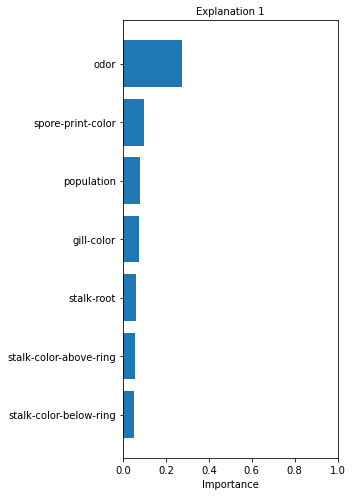

In [8]:
g.plot(num_features=7)

In [9]:
g.subpopulation_sizes

[200]

In [10]:
g.explanations


[[('cap-shape', 0.01825791031048172),
  ('cap-surface', 0.008376866042681131),
  ('cap-color', 0.042444218294873964),
  ('bruises', 0.0024356302843576874),
  ('odor', 0.2739508049117813),
  ('gill-attachment', 0.0048033050503095715),
  ('gill-spacing', 0.02403384912759166),
  ('gill-size', 0.03504489168926918),
  ('gill-color', 0.07370976099307944),
  ('stalk-shape', 0.03642743459051172),
  ('stalk-root', 0.05962940916617325),
  ('stalk-surface-above-ring', 0.02867428599040516),
  ('stalk-surface-below-ring', 0.01394072832702447),
  ('stalk-color-above-ring', 0.05483203083131509),
  ('stalk-color-below-ring', 0.05179942391181768),
  ('veil-type', 0.0),
  ('veil-color', 0.005573315795773394),
  ('ring-number', 0.005027350722649562),
  ('ring-type', 0.04809626577515543),
  ('spore-print-color', 0.09844477389331338),
  ('population', 0.07727135512413516),
  ('habitat', 0.03722638916730007)]]